In [65]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def fminmax(column):
    minx = column.min()
    maxx = column.max()
    return float(minx), float(maxx)

In [67]:
def normalise(data):
    for i in range(len(data[0])-1):
        minx, maxx = fminmax(data[:,i])
        for j in range(data.shape[0]):
            data[j][i] = (data[j][i] - minx)/(maxx - minx)
    return data

In [94]:
class NeuralNetwork:
    def __init__(self, n_hidden, nodes, n_output, n_epoch, l_rate=0.03, tol=1e-4):
        self.n_hidden = n_hidden
        self.nodes = nodes
        self.n_output = n_output
        self.n_epoch = n_epoch
        self.l_rate = l_rate
        self.tol = tol
        self.loss = []
        self.accuracy = []
        
    def fit(self,x,y):
        self.X = x

        #self.X = np.insert(self.X, 0, np.ones((self.X.shape[0],)), axis=1)

        self.weights_h1 = np.random.rand(self.X.shape[1], self.nodes)
        self.weights_h2 = np.random.rand(self.nodes, self.nodes)
        self.weights_o = np.random.rand(self.nodes, self.n_output)

        self.bias_h1 = np.random.rand(1,self.nodes) 
        self.bias_h2 = np.random.rand(1,self.nodes)
        self.bias_o = np.random.rand(1,self.n_output)
        
        self.Y = y
        shap = (int(self.X.shape[0]), int(self.n_output))
        labels = np.zeros(shap)
        for i in range(int(self.X.shape[0])):
            labels[i][int(self.Y[i])-1] = 1
        self.y = labels
        self.loss = []
        self.accuracy = []
        for epoch in range(self.n_epoch):
            self._feedforward()
            self._backpropagation()
            loss = 0
            acc = 0
            if(epoch%50 == 0):
                loss = np.sum(-self.y * np.log(self.a3))
                #print("loss = ",loss)
                self.loss.append(loss)
                for i in range(len(self.Y)):
                    if (np.argmax(self.a3[i,:]) + 1) == self.Y[i]:
                        acc += 1
                accuracy = acc*100/len(self.Y)
                print("accuracy = ",accuracy,"---loss = ",loss,"---iter",epoch)
                self.accuracy.append(accuracy)
            
            if abs(self.y - self.a3).mean()<self.tol:
                break
                
    def _feedforward(self, X=None):
        
        if X is None:
            X=self.X
        #else:
            #X = np.insert(X, 0, np.ones((X.shape[0],)), axis=1)

        z1 = np.dot(X, self.weights_h1) + self.bias_h1
        self.a1 = self._sigmoid(z1) 
        
        if self.n_hidden == 1:
            z2 = np.dot(self.a1, self.weights_o) + self.bias_o
            self.a3 = self._sigmoid(z2)
        
        else:
            z2 = np.dot(self.a1, self.weights_h2) + self.bias_h2
            self.a2 = self._sigmoid(z2)
            z3 = np.dot(self.a2, self.weights_o) + self.bias_o
            self.a3 = self._sigmoid(z3)
        
    def _sigmoid(self,z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_d(self, z):
        sd = np.exp(-z)/(1+np.exp(-z))**2
        return sd
    
    def _softmax(self,z):
        expA = np.exp(z)
        return expA / expA.sum(axis=1, keepdims=True)

    def _backpropagation(self):

        if self.n_hidden == 1:
            delta_L = self.y - self.a3

            small_delta_o = delta_L * self._sigmoid_d(self.a3) #1400;10
            big_delta_o = np.dot(self.a1.T, small_delta_o) #100;10

            small_delta_h = np.dot(small_delta_o, self.weights_o.T) * self._sigmoid_d(self.a1) #1400;100
            big_delta_h = np.dot(self.X.T, small_delta_h) #7;100

            self.weights_h1 = self.weights_h1 + self.l_rate*big_delta_h
            self.weights_o = self.weights_o + self.l_rate*big_delta_o
            self.bias_h1 = self.bias_h1 + self.l_rate*np.sum(small_delta_h, axis=0)
            self.bias_o = self.bias_o + self.l_rate*np.sum(small_delta_o, axis=0)
            
        else:
            delta_L = self.y - self.a3
       
            small_delta_o = delta_L * self._sigmoid_d(self.a3) 
            big_delta_o = np.dot(self.a2.T, small_delta_o)

            small_delta_h2 = np.dot(small_delta_o, self.weights_o.T) * self._sigmoid_d(self.a2) #1400;100
            big_delta_h2 = np.dot(self.a1.T, small_delta_h2)

            small_delta_h1 = np.dot(small_delta_h2, self.weights_h2.T) * self._sigmoid_d(self.a1) #1400;100
            big_delta_h1 = np.dot(self.X.T, small_delta_h1)

            self.weights_h1 = self.weights_h1 + self.l_rate*big_delta_h1
            self.weights_h2 = self.weights_h2 + self.l_rate*big_delta_h2
            self.weights_o = self.weights_o + self.l_rate*big_delta_o
            
            self.bias_h2 = self.bias_h2 + self.l_rate*np.sum(small_delta_h2, axis=0)
            self.bias_h1 = self.bias_h1 + self.l_rate*np.sum(small_delta_h1, axis=0)
            self.bias_o = self.bias_o + self.l_rate*np.sum(small_delta_o, axis=0)           

    def plota(self):
        ite = [i*50 for i in range(int(self.n_epoch/50))]
        plot1 = plt.figure(1)
        plt.plot(ite,self.accuracy,'b')
        plt.title("Accuracy")
        return 0
    
    def plotl(self):
        ite = [i*50 for i in range(int(self.n_epoch/50))]
        plot1 = plt.figure(2)
        plt.plot(ite,self.loss,'r')
        plt.title("Loss")
        return 0    
    
    def predict(self, X):
        self._feedforward(X)
        pred_val = []
        for i in range(X.shape[0]):
            pred_val.append(int(np.argmax(self.a3[i,:]+0.5) + 1))
        return pred_val
    
    def outr(self):
        a3 = self.a3
        return a3

In [95]:
data = pd.read_csv("dataset_NN.csv", header=None, skiprows = 1)

dataset = np.array(data)
dataset = normalise(dataset) # normalised the data
np.random.shuffle(dataset)
#print(dataset)

In [187]:
rows = dataset.shape[0]
clmns = dataset.shape[1]
classes = np.unique(dataset[:,-1]).shape[0]
t_v = int(rows*0.7)

X_train = dataset[:t_v,:-1]
Y_train = dataset[:t_v,-1]
X_test = dataset[t_v:,:-1]
Y_test = dataset[t_v:,-1]


net1=NeuralNetwork(n_hidden=1, nodes=100, n_output=10, n_epoch=10000, l_rate=0.005)
net2=NeuralNetwork(n_hidden=1, nodes=100, n_output=10, n_epoch=10000, l_rate=0.001)
net3=NeuralNetwork(n_hidden=1, nodes=100, n_output=10, n_epoch=10000, l_rate=0.0005)

net1.fit(X_train,Y_train)
net2.fit(X_train,Y_train)
net3.fit(X_train,Y_train)



accuracy =  2.5 ---loss =  8.615330671091217e-14 ---iter 0
accuracy =  55.57142857142857 ---loss =  2342.327497622029 ---iter 50
accuracy =  63.214285714285715 ---loss =  1966.6764370174171 ---iter 100
accuracy =  66.5 ---loss =  1723.7340079995433 ---iter 150
accuracy =  68.28571428571429 ---loss =  1568.679635045311 ---iter 200
accuracy =  69.07142857142857 ---loss =  1469.17239103572 ---iter 250
accuracy =  69.21428571428571 ---loss =  1402.1576413322555 ---iter 300
accuracy =  69.42857142857143 ---loss =  1353.5578594100725 ---iter 350
accuracy =  69.78571428571429 ---loss =  1315.777528861912 ---iter 400
accuracy =  69.71428571428571 ---loss =  1284.7898183144448 ---iter 450
accuracy =  69.78571428571429 ---loss =  1258.3175861987575 ---iter 500
accuracy =  70.21428571428571 ---loss =  1234.9873112438115 ---iter 550
accuracy =  70.21428571428571 ---loss =  1213.9579933536115 ---iter 600
accuracy =  70.21428571428571 ---loss =  1194.7284031858 ---iter 650
accuracy =  70.42857142857

accuracy =  76.0 ---loss =  913.0754271020869 ---iter 5850
accuracy =  76.0 ---loss =  912.9061003561175 ---iter 5900
accuracy =  76.0 ---loss =  912.750682672812 ---iter 5950
accuracy =  76.0 ---loss =  912.6080445650643 ---iter 6000
accuracy =  76.0 ---loss =  912.4771145650702 ---iter 6050
accuracy =  75.92857142857143 ---loss =  912.3568778590992 ---iter 6100
accuracy =  76.07142857142857 ---loss =  912.2463747230936 ---iter 6150
accuracy =  76.07142857142857 ---loss =  912.1446987894219 ---iter 6200
accuracy =  76.07142857142857 ---loss =  912.0509951745797 ---iter 6250
accuracy =  76.07142857142857 ---loss =  911.964458496504 ---iter 6300
accuracy =  76.07142857142857 ---loss =  911.8843308085715 ---iter 6350
accuracy =  76.07142857142857 ---loss =  911.8098994754823 ---iter 6400
accuracy =  76.14285714285714 ---loss =  911.7404950140836 ---iter 6450
accuracy =  76.14285714285714 ---loss =  911.6754889200761 ---iter 6500
accuracy =  76.14285714285714 ---loss =  911.6142914991876 

accuracy =  70.5 ---loss =  1487.4810781024908 ---iter 1700
accuracy =  70.5 ---loss =  1482.576520900005 ---iter 1750
accuracy =  70.42857142857143 ---loss =  1477.8038039776854 ---iter 1800
accuracy =  70.35714285714286 ---loss =  1473.1519284415645 ---iter 1850
accuracy =  70.5 ---loss =  1468.6114329552342 ---iter 1900
accuracy =  70.42857142857143 ---loss =  1464.1741473813559 ---iter 1950
accuracy =  70.57142857142857 ---loss =  1459.8329874801132 ---iter 2000
accuracy =  70.64285714285714 ---loss =  1455.5817827218727 ---iter 2050
accuracy =  70.78571428571429 ---loss =  1451.4151310359534 ---iter 2100
accuracy =  70.92857142857143 ---loss =  1447.3282756774693 ---iter 2150
accuracy =  71.0 ---loss =  1443.3170004422377 ---iter 2200
accuracy =  71.14285714285714 ---loss =  1439.3775402674933 ---iter 2250
accuracy =  71.14285714285714 ---loss =  1435.5065048787997 ---iter 2300
accuracy =  71.21428571428571 ---loss =  1431.700813623312 ---iter 2350
accuracy =  71.42857142857143 --

accuracy =  76.07142857142857 ---loss =  1130.3471959466106 ---iter 7600
accuracy =  76.07142857142857 ---loss =  1127.8191039972767 ---iter 7650
accuracy =  76.07142857142857 ---loss =  1125.3164149461525 ---iter 7700
accuracy =  75.92857142857143 ---loss =  1122.8395271446684 ---iter 7750
accuracy =  75.92857142857143 ---loss =  1120.3888028297952 ---iter 7800
accuracy =  75.92857142857143 ---loss =  1117.9645688542223 ---iter 7850
accuracy =  75.85714285714286 ---loss =  1115.5671174883737 ---iter 7900
accuracy =  75.85714285714286 ---loss =  1113.196707284313 ---iter 7950
accuracy =  75.85714285714286 ---loss =  1110.8535639921765 ---iter 8000
accuracy =  75.85714285714286 ---loss =  1108.5378815203517 ---iter 8050
accuracy =  75.85714285714286 ---loss =  1106.2498229312903 ---iter 8100
accuracy =  75.78571428571429 ---loss =  1103.9895214654719 ---iter 8150
accuracy =  75.78571428571429 ---loss =  1101.757081586683 ---iter 8200
accuracy =  75.92857142857143 ---loss =  1099.5525800

accuracy =  69.92857142857143 ---loss =  1479.3195738527397 ---iter 3500
accuracy =  69.92857142857143 ---loss =  1476.7189653930059 ---iter 3550
accuracy =  69.92857142857143 ---loss =  1474.1570311026153 ---iter 3600
accuracy =  69.92857142857143 ---loss =  1471.6326269670808 ---iter 3650
accuracy =  70.0 ---loss =  1469.1446849154959 ---iter 3700
accuracy =  70.07142857142857 ---loss =  1466.6922050029748 ---iter 3750
accuracy =  70.0 ---loss =  1464.2742485146186 ---iter 3800
accuracy =  70.0 ---loss =  1461.889931888034 ---iter 3850
accuracy =  70.07142857142857 ---loss =  1459.5384213611826 ---iter 3900
accuracy =  70.07142857142857 ---loss =  1457.2189282611928 ---iter 3950
accuracy =  70.07142857142857 ---loss =  1454.930704857782 ---iter 4000
accuracy =  70.07142857142857 ---loss =  1452.673040712294 ---iter 4050
accuracy =  70.21428571428571 ---loss =  1450.4452594600725 ---iter 4100
accuracy =  70.21428571428571 ---loss =  1448.246715970075 ---iter 4150
accuracy =  70.142857

accuracy =  73.64285714285714 ---loss =  1300.1735693931591 ---iter 9350
accuracy =  73.78571428571429 ---loss =  1298.83273399596 ---iter 9400
accuracy =  73.78571428571429 ---loss =  1297.483707818305 ---iter 9450
accuracy =  73.78571428571429 ---loss =  1296.1264525403813 ---iter 9500
accuracy =  73.85714285714286 ---loss =  1294.7609401933453 ---iter 9550
accuracy =  73.92857142857143 ---loss =  1293.3871529673938 ---iter 9600
accuracy =  73.92857142857143 ---loss =  1292.0050830182756 ---iter 9650
accuracy =  74.07142857142857 ---loss =  1290.6147322731672 ---iter 9700
accuracy =  74.14285714285714 ---loss =  1289.2161122367256 ---iter 9750
accuracy =  74.28571428571429 ---loss =  1287.8092437980313 ---iter 9800
accuracy =  74.21428571428571 ---loss =  1286.3941570390066 ---iter 9850
accuracy =  74.35714285714286 ---loss =  1284.970891044802 ---iter 9900
accuracy =  74.35714285714286 ---loss =  1283.5394937165192 ---iter 9950


In [188]:
y_pred=net1.predict(X_test)
acc = 0
accu, lossu = [], []
for i in range(len(Y_test)):
    if y_pred[i] == Y_test[i]:
        acc += 1
accuracy = acc*100/len(Y_test)
print(accuracy)
accu.append(accuracy)

72.5


In [189]:
a3 = net1.outr()
loss = 0
for i in range(len(Y_test)):
    loss += Y_test[i] * np.sum(a3[i])
print(loss)
lossu.append(loss)

3220.677773719641


In [190]:
y_pred=net2.predict(X_test)
acc = 0
for i in range(len(Y_test)):
    if y_pred[i] == Y_test[i]:
        acc += 1
accuracy = acc*100/len(Y_test)
print(accuracy)
accu.append(accuracy)

73.5


In [191]:
a3 = net2.outr()
loss = 0
for i in range(len(Y_test)):
    loss += Y_test[i] * np.sum(a3[i])
print(loss)
lossu.append(loss)

3222.207909126015


In [192]:
y_pred=net3.predict(X_test)
acc = 0
for i in range(len(Y_test)):
    if y_pred[i] == Y_test[i]:
        acc += 1
accuracy = acc*100/len(Y_test)
print(accuracy)
accu.append(accuracy)

71.66666666666667


In [193]:
a3 = net3.outr()
loss = 0
for i in range(len(Y_test)):
    loss += Y_test[i] * np.sum(a3[i])
print(loss)
lossu.append(loss)

3044.07633593912


Text(0.5, 1.0, 'Loss vs Lr')

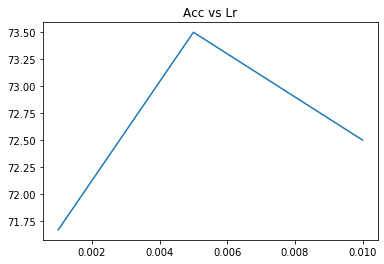

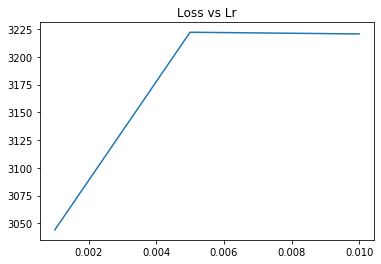

In [194]:
lr = [0.01, 0.005, 0.001]
plt.figure(1)
plt.plot(lr,accu)
plt.title("Acc vs Lr")
plt.figure(2)
plt.plot(lr,lossu)
plt.title("Loss vs Lr")

0

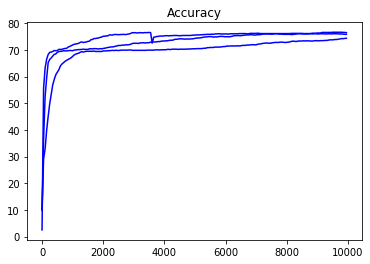

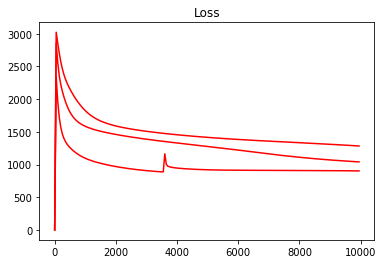

In [195]:
net1.plota()
net1.plotl()
net2.plota()
net2.plotl()
net3.plota()
net3.plotl()